# Supervised learning- regression- knn and penalisation


! You will need to install python 3.10.9 to run the demo and labo of this class (do not remove python 3.11)


# 0. Loading packages and dataset

In [24]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('insurance_cleaned.csv')
df.head()

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,9.734236,1,0,0,1,0,0,0,1
1,18,33.770,1,7.453882,0,1,1,0,0,0,1,0
2,28,33.000,3,8.400763,0,1,1,0,0,0,1,0
3,33,22.705,0,9.998137,0,1,1,0,0,1,0,0
4,32,28.880,0,8.260455,0,1,1,0,0,1,0,0


In [25]:
## 0.1. Train/test-split

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from random import Random

df_shuffle = df.sample(frac=1, random_state=40)

X = df_shuffle.drop(columns='charges')
y = df_shuffle['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

num = ['age','bmi','children']
scaler = StandardScaler()
X_train_stand = X_train.copy()
X_test_stand = X_test.copy()
X_train_stand[num] = scaler.fit_transform(X_train[num])
X_test_stand[num] = scaler.transform(X_test[num])

In [27]:
X_train_stand.head()

,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
217,-0.870587,-1.225955,-0.901777,0,1,1,0,0,0,1,0
1060,-1.084879,0.234041,-0.901777,0,1,1,0,0,0,1,0
555,-0.799156,-1.111253,0.740608,0,1,1,0,0,0,0,1
1155,-0.227711,-1.384080,1.561801,1,0,1,0,1,0,0,0
888,-1.227741,1.461355,-0.901777,0,1,1,0,0,0,0,1


In [28]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1070 entries, 217 to 52
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               1070 non-null   int64  
 1   bmi               1070 non-null   float64
 2   children          1070 non-null   int64  
 3   sex_female        1070 non-null   int64  
 4   sex_male          1070 non-null   int64  
 5   smoker_no         1070 non-null   int64  
 6   smoker_yes        1070 non-null   int64  
 7   region_northeast  1070 non-null   int64  
 8   region_northwest  1070 non-null   int64  
 9   region_southeast  1070 non-null   int64  
 10  region_southwest  1070 non-null   int64  
dtypes: float64(1), int64(10)
memory usage: 100.3 KB


# 1. Decision trees

We start with a simple decision tree, but use cross-validation with regard to the maximum depth to find the best model. Since there are 1070 observation, the depth can't be higher than 11.

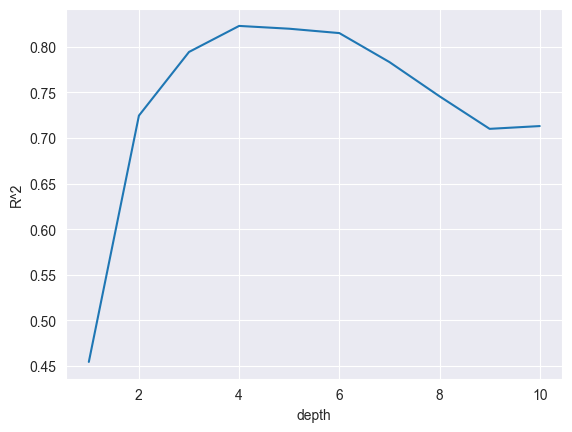

The best depth is 4
The validated score is 0.82275796207586


In [29]:
from sklearn.tree import DecisionTreeRegressor  
from sklearn.model_selection import cross_val_score

depth = np.arange(1,11)    # This will give an array of numbers between 1 and 10
cv_scores = []
sd_scores = []
# perform 5-fold cross validation on the  possible values for the radius (bandwith)
for d in depth:
    dec_tree = DecisionTreeRegressor(random_state = 0, max_depth=d)  
    scores = cross_val_score(dec_tree, X_train_stand, y_train,  cv=5)
    cv_scores.append(scores.mean())
    sd_scores.append(np.sqrt(scores.var())/np.sqrt(5))
 
max_value = max(cv_scores)
max_index = cv_scores.index(max_value)

plt.plot(depth, cv_scores)
plt.xlabel('depth')
plt.ylabel('R^2')

plt.show()
print('The best depth is', depth[max_index])
print('The validated score is', max_value)

4 is the best model. We use this model

In [30]:
from sklearn import tree  
dec_tree = DecisionTreeRegressor(random_state = 0, max_depth=depth[max_index])  
dec_tree.fit(X_train_stand, y_train) 
print(dec_tree.score(X_train_stand, y_train) )
print(max_value)

0.8444535205469329
0.82275796207586


# 2. Random forest
Let's see if we can improve this by using random forests. 

In [31]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

criterion =['squared_error','absolute_error']
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 400)]
max_depth = [int(x) for x in np.linspace(1, 10, num = 10)]
min_samples_split = [int(x) for x in np.linspace(2, 10, num = 9)]
min_samples_leaf = [int(x) for x in np.linspace(1, 10, num = 10)]
max_leaf_nodes = [int(x) for x in np.linspace(10, 500, num = 490)]

# create the random grid to search for best hyperparameters
random_grid = {'criterion': criterion,
               'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_leaf_nodes': max_leaf_nodes}

# then do cross-validatoin
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, 
                               cv = 3, verbose=5, random_state=42, n_jobs=-1)
# n_jobs=-1 to run as many models  parallel as possible
rf_random.fit(X_train_stand, y_train)



Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'criterion': ['squared_error',
                                                      'absolute_error'],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10],
                                        'max_leaf_nodes': [10, 11, 12, 13, 14,
                                                           15, 16, 17, 18, 19,
                                                           20, 21, 22, 23, 24,
                                                           25, 26, 27, 28, 29,
                                                           30, 31, 32, 33, 34,
                                                           35, 36, 37, 38, 39, ...],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10],
                                        'n_estimators': [100, 101, 102, 103,
                                                         104, 105, 106, 107,
                                                         108, 109, 110, 111,
                                                         112, 113, 114, 115,
                                                         116, 117, 118, 119,
                                                         120, 121, 122, 123,
                                                         124, 125, 126, 127,
                                                         128, 129, ...]},
                   random_state=42, verbose=5)

In [32]:
print(rf_random.score(X_train_stand, y_train)) # training score
print(rf_random.best_score_)  # validation score

0.8556084000446534
0.8388042570368546


In [33]:
rf_random.best_params_

{'n_estimators': 143,
 'min_samples_split': 4,
 'min_samples_leaf': 7,
 'max_leaf_nodes': 474,
 'max_depth': 8,
 'criterion': 'absolute_error'}

In [34]:
out = pd.DataFrame(rf_random.cv_results_)
out.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_leaf_nodes,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,2.820502,0.296147,0.035173,0.003800,295,10,8,172,2,absolute_error,"{'n_estimators': 295, 'min_samples_split': 10,...",0.704201,0.775659,0.767757,0.749206,0.031986,84
1,3.224832,0.049996,0.034541,0.003217,192,8,1,223,9,absolute_error,"{'n_estimators': 192, 'min_samples_split': 8, ...",0.788328,0.827314,0.868091,0.827911,0.032566,69
2,5.975377,0.100227,0.047198,0.003075,402,5,6,121,5,absolute_error,"{'n_estimators': 402, 'min_samples_split': 5, ...",0.785731,0.848559,0.870261,0.834850,0.035845,22
3,1.030018,0.087843,0.061180,0.010405,363,8,3,122,8,squared_error,"{'n_estimators': 363, 'min_samples_split': 8, ...",0.792257,0.823900,0.866121,0.827426,0.030258,70
4,0.384878,0.045713,0.021846,0.003355,138,8,7,280,8,squared_error,"{'n_estimators': 138, 'min_samples_split': 8, ...",0.796430,0.836006,0.867223,0.833220,0.028968,44


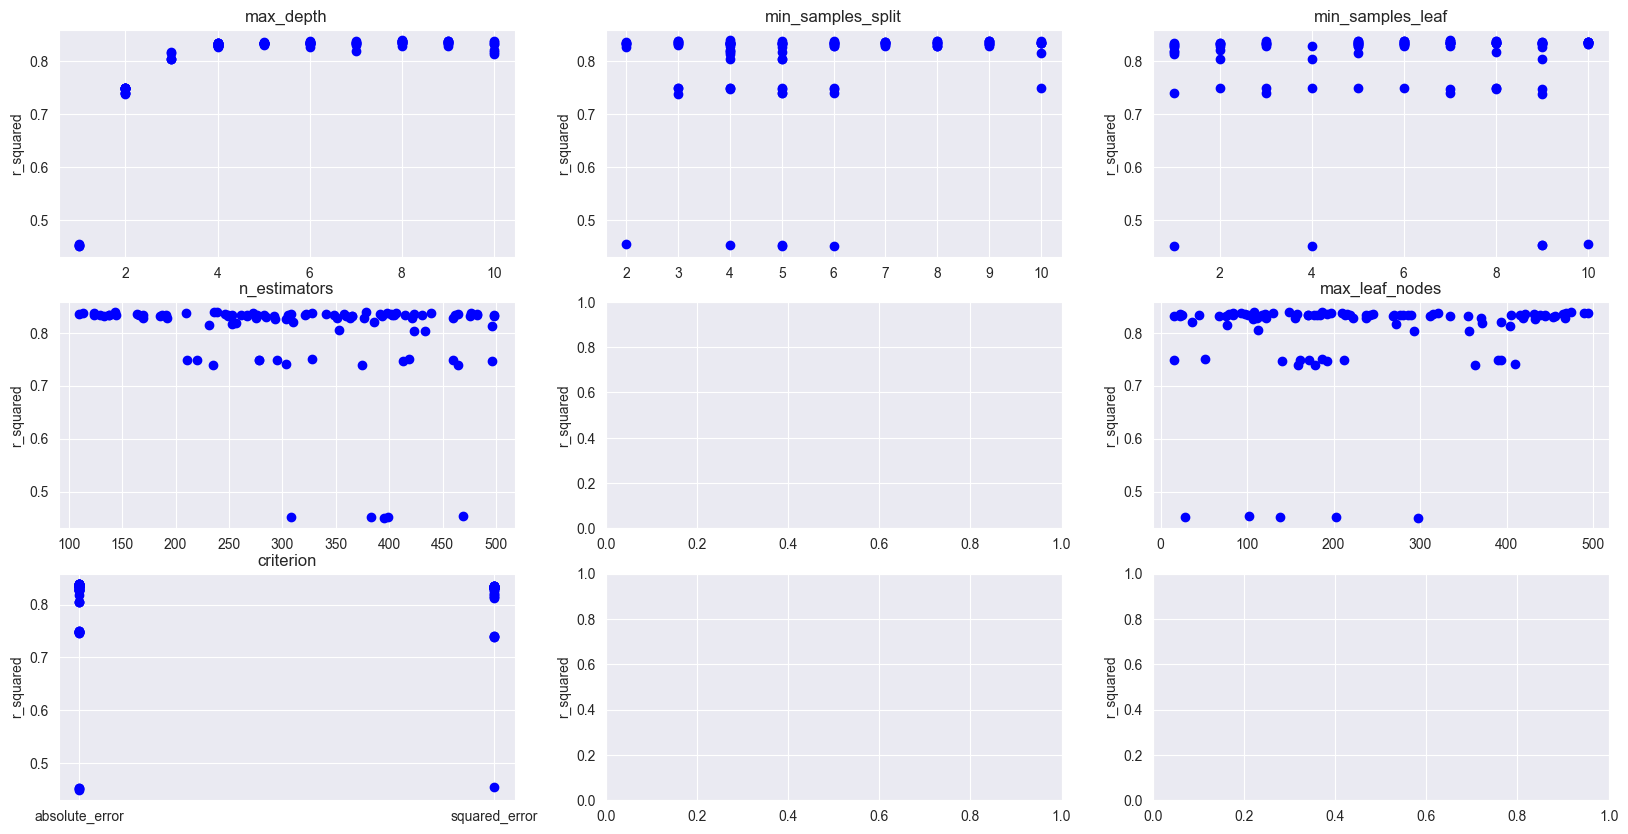

In [35]:

xlabel_names = ['param_max_depth','param_min_samples_split','param_min_samples_leaf','param_n_estimators',
                'param_max_leaf_nodes', 'param_criterion']

fig, axs = plt.subplots(3,3, figsize=(20,10))

axs[0,0].scatter(out['param_max_depth'], out['mean_test_score'], c='blue');
axs[0,0].set_title('max_depth')

axs[0,1].scatter(out['param_min_samples_split'], out['mean_test_score'], c='blue');
axs[0,1].set_title('min_samples_split')

axs[0,2].scatter(out['param_min_samples_leaf'], out['mean_test_score'], c='blue');
axs[0,2].set_title('min_samples_leaf')

axs[1,0].scatter(out['param_n_estimators'], out['mean_test_score'], c='blue');
axs[1,0].set_title('n_estimators')


axs[1,2].scatter(out['param_max_leaf_nodes'], out['mean_test_score'], c='blue');
axs[1,2].set_title('max_leaf_nodes')

axs[2,0].scatter(out['param_criterion'], out['mean_test_score'], c='blue');
axs[2,0].set_title('criterion')

for ax in axs.flat:
    ax.set(ylabel='r_squared')
    

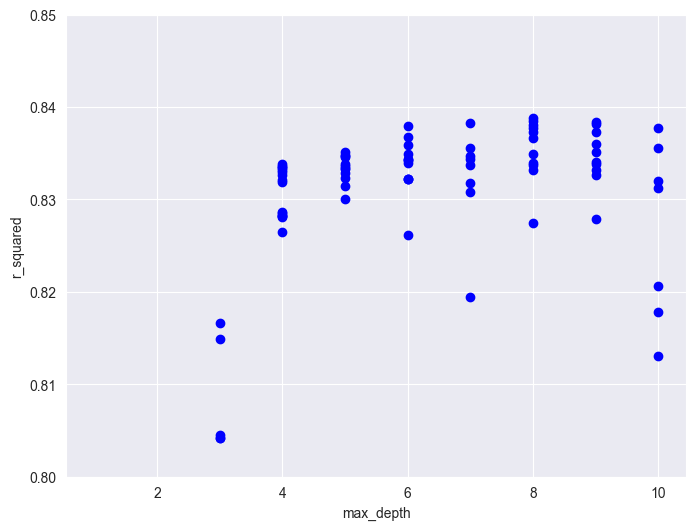

In [36]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(out['param_max_depth'], out['mean_test_score'], c='blue');
ax.set_xlabel("max_depth");
ax.set_ylabel("r_squared");
ax.set_ylim([0.8,0.85]);

We can see that the best depth is 8, but 7, 9 and 10 do not perform much worse. However, we prefer models that are less complex. Here, that means models that are less deep. So, we chose 7 and 8 to go in the grid search.

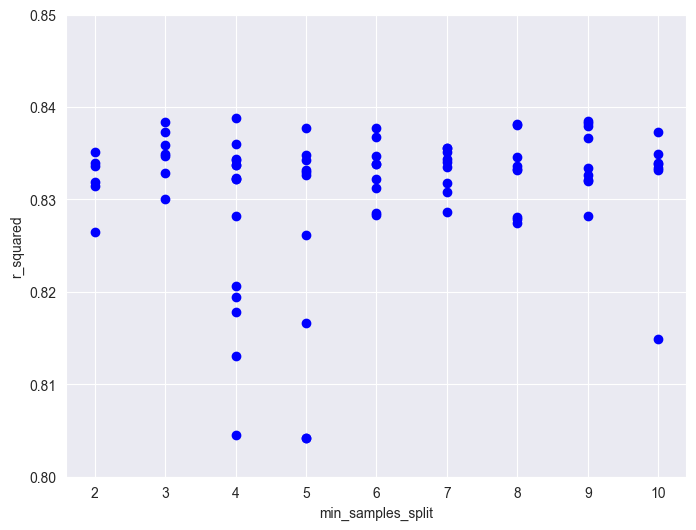

In [37]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(out['param_min_samples_split'], out['mean_test_score'], c='blue');
ax.set_xlabel("min_samples_split");
ax.set_ylabel("r_squared");
ax.set_ylim([0.8,0.85]);

We can see that the best value is 4, but 3, 5 ,8 and 9 do not perform much worse. However, we prefer models that are less complex. Here, that means models that have a higher min number of samples to allow splitting. So, we chose 4 and 9 to go in the grid search.

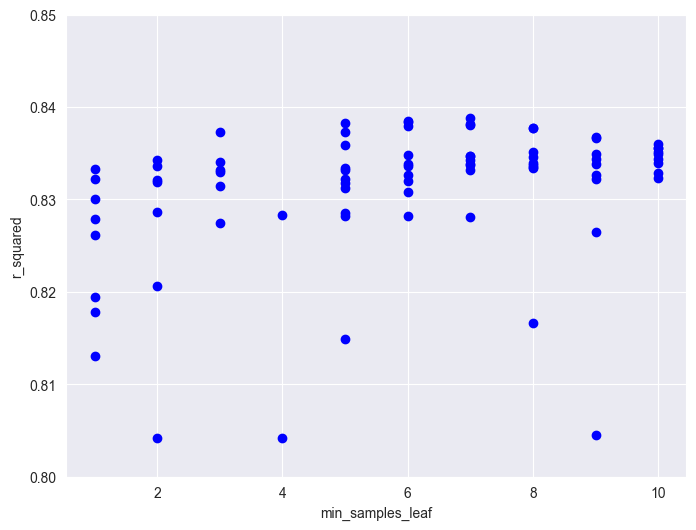

In [38]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(out['param_min_samples_leaf'], out['mean_test_score'], c='blue');
ax.set_xlabel("min_samples_leaf");
ax.set_ylabel("r_squared");
ax.set_ylim([0.8,0.85]);

7 leads to the best R^2, but 6 and 8 is  not that much worse. We prefer a higher number of samples in a leaf (less complex), thus we include 7 and 8.

NameError: name 'out' is not defined

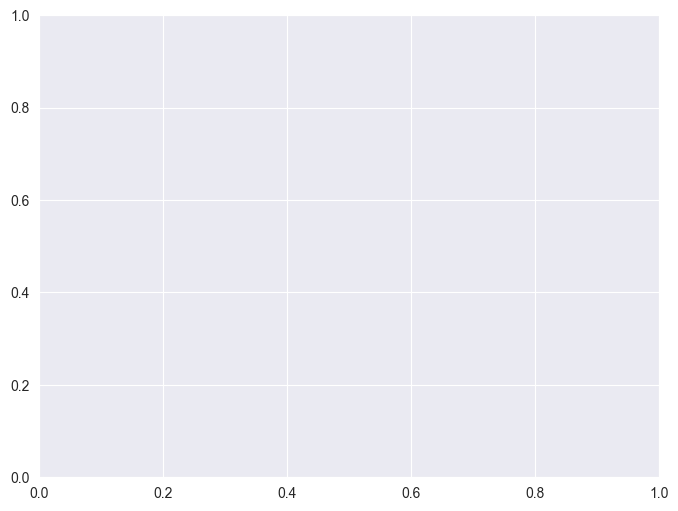

In [12]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(out['param_n_estimators'], out['mean_test_score'], c='blue');
ax.set_xlabel("n_estimators");
ax.set_ylabel("r_squared");
ax.set_ylim([0.8,0.85]);

The best value was with 143 trees. 480 is not much worse, but that makes the model more complex. Let's add  140,143,146 to the grid search. (normally you would test more values, but here we want it to go fast)

log2  wins here, but the difference is small. Let's add log2 (in reality I would keep both)

NameError: name 'out' is not defined

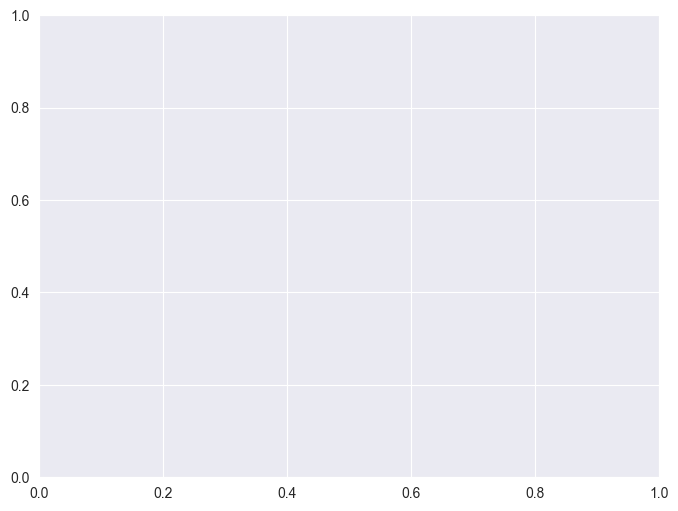

In [13]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(out['param_max_leaf_nodes'], out['mean_test_score'], c='blue');
ax.set_xlabel("max_leaf_nodes");
ax.set_ylabel("r_squared");
ax.set_ylim([0.8,0.85]);


The best max_leaf_nodes was 474. Let add some values around 474

NameError: name 'out' is not defined

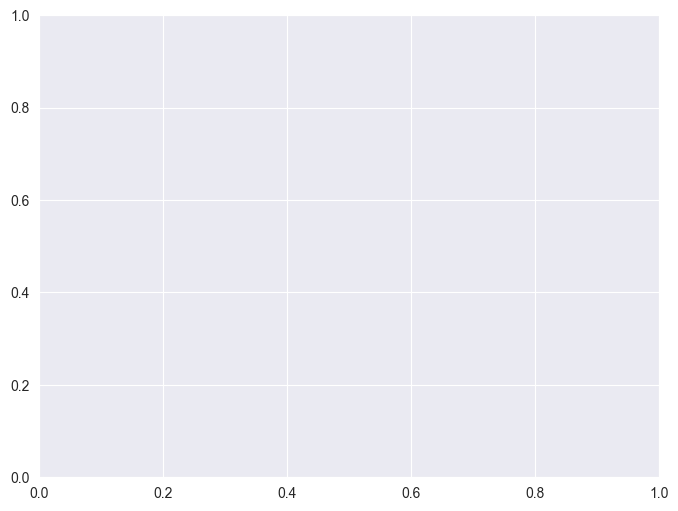

In [14]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(out['param_criterion'], out['mean_test_score'], c='blue');
ax.set_xlabel("criterion");
ax.set_ylabel("r_squared");
ax.set_ylim([0.8,0.85]);

absolute error had the best score, so  we will include only absolute score.

Note: add more values to your grid for the project. I really limited myself here, so the model would not run too long for the demo

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

criterion =['absolute_error']
n_estimators = [140, 143,146]
max_depth = [7,8]
min_samples_split = [4,9]
min_samples_leaf = [7,8]
max_leaf_nodes = [int(x) for x in np.linspace(472, 476, num = 3)]

# create the random grid to search for best hyperparameters
grid = {'criterion': criterion,
               'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_leaf_nodes': max_leaf_nodes
}



# then do cross-validatoin
rf = RandomForestRegressor()
rf_grid = GridSearchCV(estimator = rf, param_grid = grid,
                               cv = 5, verbose=2,  n_jobs=-1)
# n_jobs=-1 to run as many models  parallel as possible
rf_grid.fit(X_train_stand, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'criterion': ['absolute_error'], 'max_depth': [7, 8],
                         'max_leaf_nodes': [472, 474, 476],
                         'min_samples_leaf': [7, 8],
                         'min_samples_split': [4, 9],
                         'n_estimators': [140, 143, 146]},
             verbose=2)

In [20]:
print(rf_grid.score(X_train_stand, y_train)) 
print(rf_grid.best_score_)

0.8547143167742751
0.8396581255670682


In [21]:
rf_grid.best_params_

{'criterion': 'absolute_error',
 'max_depth': 8,
 'max_leaf_nodes': 474,
 'min_samples_leaf': 7,
 'min_samples_split': 4,
 'n_estimators': 146}

Not a lot has changed, the validation score improved a bit.
We retrain the model with the best parameters on the whole training set, before we take a look at whitening the black box

In [22]:
params = rf_grid.best_params_
rf_gridBest = RandomForestRegressor(**params)
rf_gridBest.fit(X_train_stand, y_train)


RandomForestRegressor(criterion='absolute_error', max_depth=8,
                      max_leaf_nodes=474, min_samples_leaf=7,
                      min_samples_split=4, n_estimators=146)

# 3. Whitening the black box

Random forest is good all-round algorithm. It may not always be the very best, but it will almost always lead to a very reasonable performance, whithout a lot of effort. However, in linear regression we had the beta-parameters, which are easy to interpret. In random forest, it becomes a lot harder to interpret your results. This is why machine learning is often referred to as a black box. However, there are ways to whiten this black box. We will try to find an anwer for three questions
1. Which features are important?
2. What is the influence of a certain feature?
3. Why is a prediction what it is?	

## 3.1 Which features are important?

You can ask for the variable importance by using the function .feature_importances_

In [23]:
list(zip(X_train.columns, rf_gridBest.feature_importances_))

[('age', 0.5275259080705313),
 ('bmi', 0.07913190731265317),
 ('children', 0.04907285837326914),
 ('sex_female', 0.004680624798606011),
 ('sex_male', 0.005218404227140356),
 ('smoker_no', 0.13765261662929726),
 ('smoker_yes', 0.1908000620186892),
 ('region_northeast', 0.0024133748659433533),
 ('region_northwest', 0.00047040833613547217),
 ('region_southeast', 0.0016496351721952797),
 ('region_southwest', 0.001384200195539455)]

This is not easy to read, so it is better to plot this. But first, let's check if the sum of all feature importances is indeed 1.

In [24]:
rf_gridBest.feature_importances_.sum()

1.0

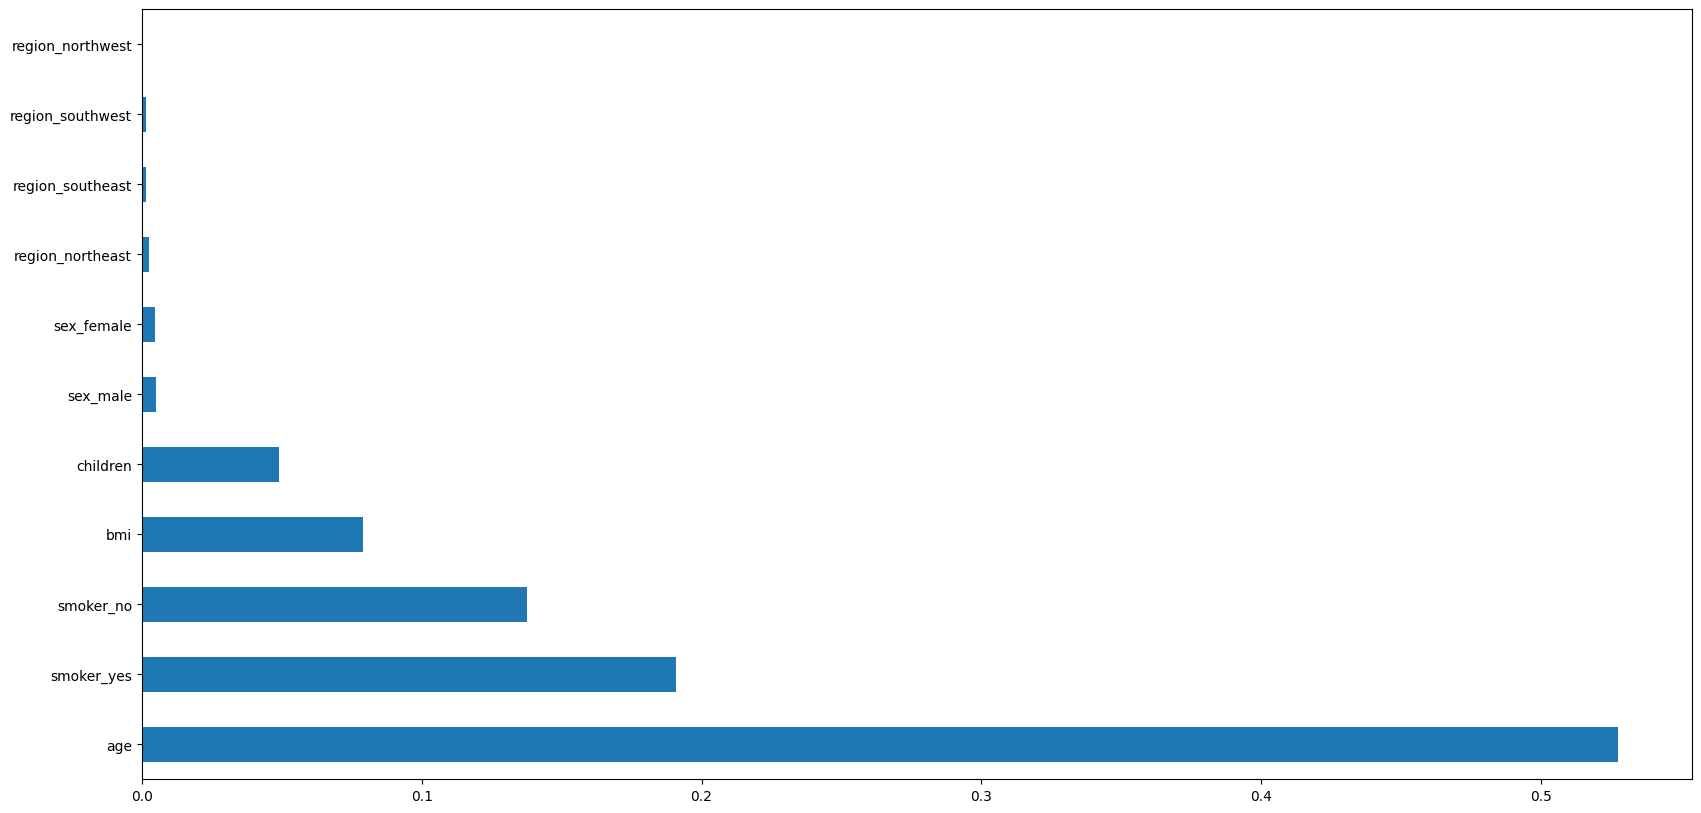

In [25]:
from matplotlib import pyplot as plt

plt.figure(figsize=(20,10))

feat_importances = pd.Series(rf_gridBest.feature_importances_, index=X.columns)
feat_importances.nlargest(11).plot(kind='barh')
plt.show()


So, the five features that seem to have the most influence in our algorithm are the number of children, bmi, not smoking, smoking and age.

But in what is the direction of this influence? Here, you might guess it from the context ( being older will probably result in higher medical costs), but be carefull with making assumptions like that. There is always a chance that you are wrong. So you have to check the directions of the influences yourself.

Another way to check the importance of features is to calculate the permutation importance using the eli5-package. This permutes the values of each feature one by one and checks how it changes model performance.

## 3.2 What is the influence of a certain feature?

Now that we know which are the important features, we can try to figure our how they are related to the outcome.  To this end, we build a regression on a set of predictions. It really doesn't matter in which set you calculate this, as long as it is representative of the population you want to discuss. Here, we do it just for the train set.

The first step is to get the predictions from the random forest.

In [26]:

pred_train =rf_gridBest.predict(X_train_stand)

We then perform one univariate linear regressions per feature on the predicted values!

We use the standardized features and also standardize the predictions, to make the interpretation easier (will be a number between -1 and 1). 

In [27]:
from sklearn.linear_model import LinearRegression

scaler2 = StandardScaler()
X_train_stand2 = X_train.copy()
X_train_stand2 = scaler.fit_transform(X_train)

X = pd.DataFrame(X_train_stand2)
X.columns = X_train.columns
predictors =  X_train.columns


y = np.array((pred_train-pred_train.mean())/np.sqrt(pred_train.var())).reshape(-1, 1)
reg = LinearRegression().fit(X[[predictors[0]]], y)
beta = pd.Series(reg.coef_[0])
names = pd.Series(predictors[0])

for i in np.arange(1,(X.shape[1])):
    reg = LinearRegression().fit(X[[predictors[i]]], y)
    beta_help = pd.Series(reg.coef_[0])
    names_help = pd.Series(predictors[i])
    beta = pd.concat([beta,beta_help], axis=0)
    names = pd.concat([names,names_help], axis=0)
betas = pd.concat([names,beta],axis=1)
betas


,0,1
0,age,0.575115
0,bmi,0.149331
0,children,0.143293
0,sex_female,-0.024104
0,sex_male,0.024104
0,smoker_no,-0.736117
0,smoker_yes,0.736117
0,region_northeast,0.024854
0,region_northwest,-0.023846
0,region_southeast,0.033211



We can see that how older you are, the higher the costs; having more children lead to higher costs; being female leads to lower costs, while being male then ofcourse leads to higher costs.

## 3.3 Why is a prediction what it is?

Now say we have a prediction that seems odd (e.g the prediction is far of the true value). You would like to know how your model came to that prediction.



In [28]:
import lime
import lime.lime_tabular
from lime.lime_tabular import LimeTabularExplainer


# creating the explainer function
explainer = LimeTabularExplainer(X_train_stand.values, mode="regression", feature_names=X_train.columns)

# storing a new observation
i = 100
X_test_stand = pd.DataFrame(X_test_stand)
X_test_stand.columns = X_train.columns

X_observation = X_test_stand.iloc[[i], :]

In [30]:
rf_gridBest.predict(X_observation)

array([9.78084034])

In [31]:
# explanation using the random forest model
explanation = explainer.explain_instance(X_observation.values[0], rf_gridBest.predict)
explanation.show_in_notebook(show_table=True, show_all=False)


c:\Users\ines.devlieger\.virtualenvs\les4_demo_labo-34krT2bv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


We can see that the prediction for this point is 9.78 (middle of the left bar). By permuting the values of the different features, the prediction ranged from 7.29 to 10.79. In the table on the right, we can see the point itself. In the graph in the middle, you can see how the features influence the point. So, if you are a smoker (smoker_yes > 0), this will have a positive impact on the prediction (the prediction will be higher with 0.80). If the standardized age is lower than -0.87, the prediction will be lower with 0.80

# 4. Gradient boosting
Let's add one last algorithm for regression. After this, we will move on to classification.


In [32]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor


n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 50)]
max_depth = [int(x) for x in np.linspace(1, 10, num = 10)]
min_samples_split = [int(x) for x in np.linspace(2, 10, num = 9)]
min_samples_leaf = [int(x) for x in np.linspace(1, 10, num = 10)]
max_leaf_nodes = [int(x) for x in np.linspace(10, 500, num = 50)]
loss = ['absolute_error', 'quantile', 'squared_error', 'huber']
learning_rate = [round(x,5) for x in np.logspace(start = -3, stop = -0.01, num = 20)]

# create the random grid to search for best hyperparameters
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_leaf_nodes': max_leaf_nodes,
               'loss': loss,
               'learning_rate': learning_rate}

# then do cross-validatoin
gbm = GradientBoostingRegressor()
gbm_random = RandomizedSearchCV(estimator = gbm, param_distributions = random_grid, n_iter = 100, 
                               cv = 3, verbose=2, random_state=42, n_jobs=-1)
gbm_random.fit(X_train_stand, y_train)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=GradientBoostingRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.001, 0.00144,
                                                          0.00206, 0.00297,
                                                          0.00426, 0.00612,
                                                          0.00879, 0.01264,
                                                          0.01815, 0.02608,
                                                          0.03747, 0.05383,
                                                          0.07734, 0.11112,
                                                          0.15965, 0.22936,
                                                          0.32953, 0.47344,
                                                          0.68019, 0.97724],
                                        'loss': ['absolute_error', 'quantile',
                                                 'squared_error', 'huber'],
                                        'max_dept...
                                                           60, 70, 80, 90, 100,
                                                           110, 120, 130, 140,
                                                           150, 160, 170, 180,
                                                           190, 200, 210, 220,
                                                           230, 240, 250, 260,
                                                           270, 280, 290, 300, ...],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10],
                                        'n_estimators': [100, 108, 116, 124,
                                                         132, 140, 148, 157,
                                                         165, 173, 181, 189,
                                                         197, 206, 214, 222,
                                                         230, 238, 246, 255,
                                                         263, 271, 279, 287,
                                                         295, 304, 312, 320,
                                                         328, 336, ...]},
                   random_state=42, verbose=2)

In [33]:
print(gbm_random.score(X_train_stand, y_train))
print(gbm_random.best_score_)

0.8605946852188562
0.8420620684766748


In [34]:
gbm_random.best_params_

{'n_estimators': 410,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_leaf_nodes': 60,
 'max_depth': 3,
 'loss': 'huber',
 'learning_rate': 0.15965}

In [35]:
out = pd.DataFrame(gbm_random.cv_results_)
out.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_leaf_nodes,param_max_depth,param_loss,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,5.480552,0.522250,0.017281,0.006888,393,4,3,130,3,quantile,0.00879,"{'n_estimators': 393, 'min_samples_split': 4, ...",-0.027998,0.272075,0.124350,0.122809,0.122509,90
1,7.741987,0.884830,0.018198,0.005644,206,10,2,390,7,absolute_error,0.15965,"{'n_estimators': 206, 'min_samples_split': 10,...",0.790914,0.834953,0.859272,0.828380,0.028291,20
2,1.880306,0.272154,0.008167,0.000206,230,2,1,120,1,quantile,0.47344,"{'n_estimators': 230, 'min_samples_split': 2, ...",-0.001346,0.282727,0.055968,0.112450,0.122656,91
3,6.354694,0.998278,0.038977,0.036139,263,8,1,360,6,quantile,0.32953,"{'n_estimators': 263, 'min_samples_split': 8, ...",0.540585,0.619632,0.552065,0.570761,0.034874,64
4,6.802495,0.725750,0.022928,0.013369,410,5,4,60,3,huber,0.15965,"{'n_estimators': 410, 'min_samples_split': 5, ...",0.796266,0.849635,0.880285,0.842062,0.034716,1


In [36]:
out.mean_test_score 

0     0.122809
1     0.828380
2     0.112450
3     0.570761
4     0.842062
        ...   
95    0.804515
96    0.498492
97    0.825999
98    0.620504
99    0.835976
Name: mean_test_score, Length: 100, dtype: float64

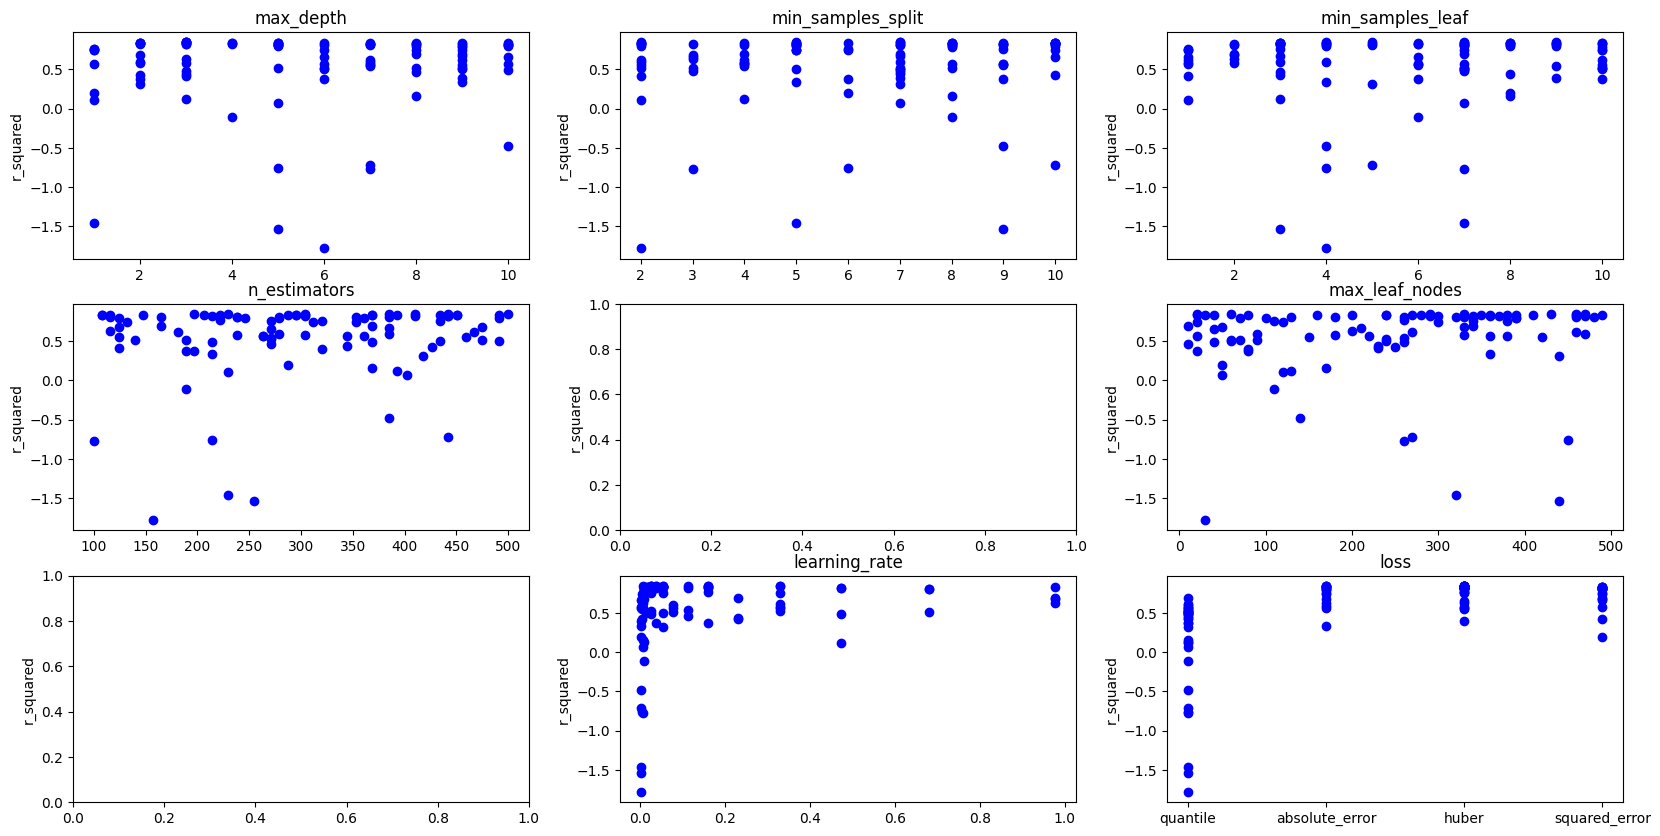

In [37]:
out2 = out


xlabel_names = ['param_max_depth','param_min_samples_split','param_min_samples_leaf','param_n_estimators',
                 'param_max_leaf_nodes']

fig, axs = plt.subplots(3,3, figsize=(20,10))

axs[0,0].scatter(out2['param_max_depth'], out2['mean_test_score'], c='blue');
axs[0,0].set_title('max_depth')

axs[0,1].scatter(out2['param_min_samples_split'], out2['mean_test_score'], c='blue');
axs[0,1].set_title('min_samples_split')

axs[0,2].scatter(out2['param_min_samples_leaf'], out2['mean_test_score'], c='blue');
axs[0,2].set_title('min_samples_leaf')

axs[1,0].scatter(out2['param_n_estimators'], out2['mean_test_score'], c='blue');
axs[1,0].set_title('n_estimators')


axs[1,2].scatter(out2['param_max_leaf_nodes'], out2['mean_test_score'], c='blue');
axs[1,2].set_title('max_leaf_nodes')

axs[2,1].scatter(out2['param_learning_rate'], out2['mean_test_score'], c='blue');
axs[2,1].set_title('learning_rate')

axs[2,2].scatter(out2['param_loss'], out2['mean_test_score'], c='blue');
axs[2,2].set_title('loss')


for ax in axs.flat: ax.set(ylabel='r_squared')

It is hard to see anything on these graphs, because of some very low scores. We will zoom in on the R^2 above 0.7

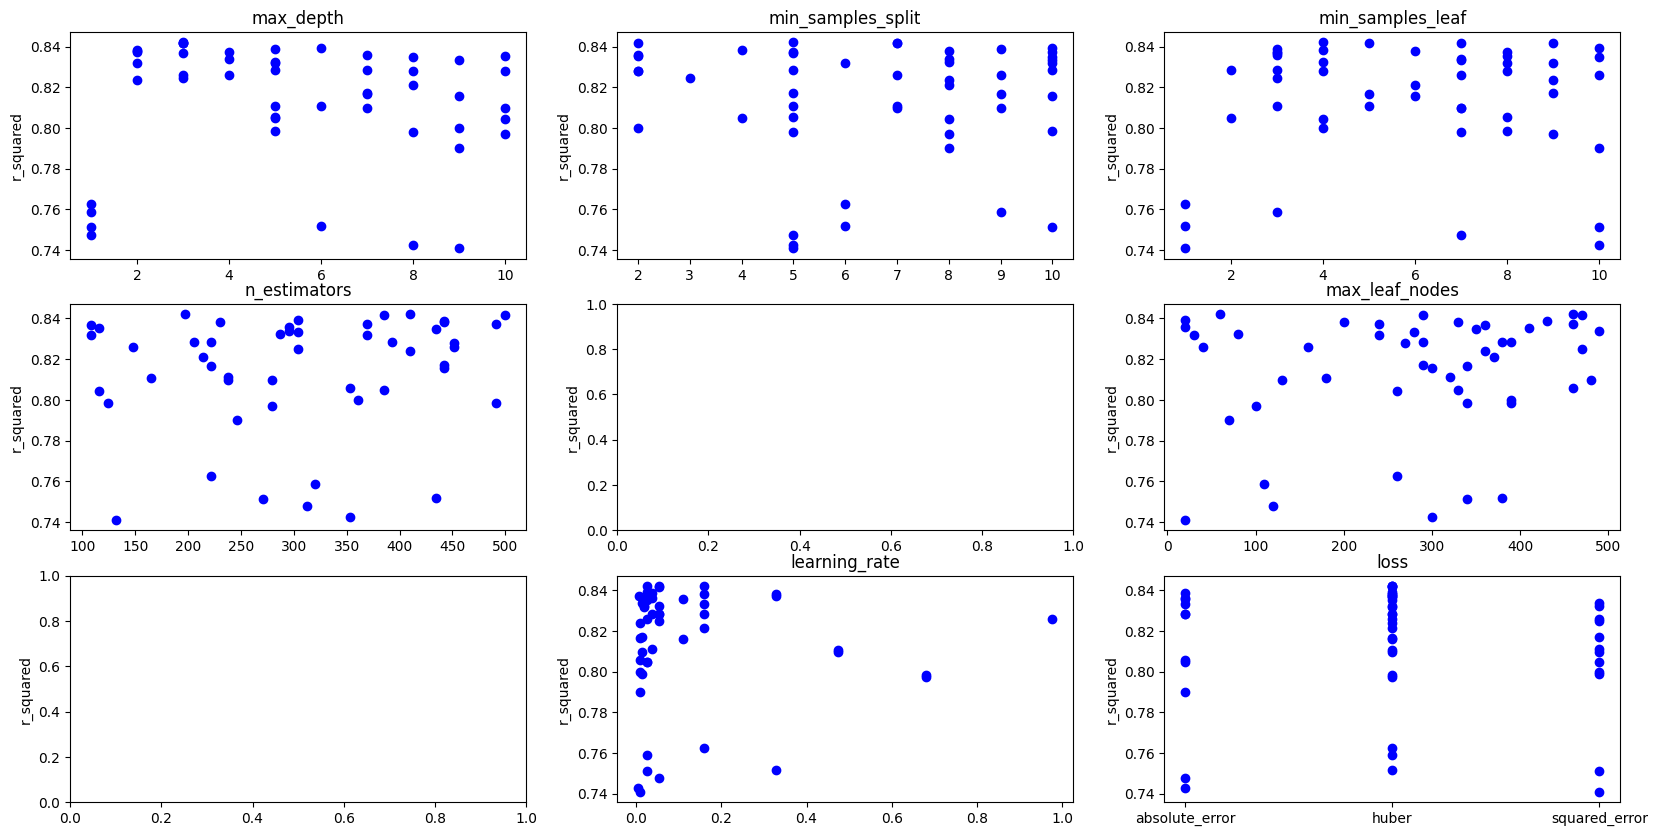

In [38]:
out2 = out[out.mean_test_score > 0.7]


xlabel_names = ['param_max_depth','param_min_samples_split','param_min_samples_leaf','param_n_estimators',
                 'param_max_leaf_nodes', 'param_criterion']

fig, axs = plt.subplots(3,3, figsize=(20,10))

axs[0,0].scatter(out2['param_max_depth'], out2['mean_test_score'], c='blue');
axs[0,0].set_title('max_depth')

axs[0,1].scatter(out2['param_min_samples_split'], out2['mean_test_score'], c='blue');
axs[0,1].set_title('min_samples_split')

axs[0,2].scatter(out2['param_min_samples_leaf'], out2['mean_test_score'], c='blue');
axs[0,2].set_title('min_samples_leaf')

axs[1,0].scatter(out2['param_n_estimators'], out2['mean_test_score'], c='blue');
axs[1,0].set_title('n_estimators')


axs[1,2].scatter(out2['param_max_leaf_nodes'], out2['mean_test_score'], c='blue');
axs[1,2].set_title('max_leaf_nodes')


axs[2,1].scatter(out2['param_learning_rate'], out2['mean_test_score'], c='blue');
axs[2,1].set_title('learning_rate')

axs[2,2].scatter(out2['param_loss'], out2['mean_test_score'], c='blue');
axs[2,2].set_title('loss')


for ax in axs.flat: ax.set(ylabel='r_squared')
    

In [39]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

n_estimators = [172,173,174]
max_depth = [4,5]
min_samples_split = [5,7]
min_samples_leaf = [7,10]
max_leaf_nodes = [129,130,131]
learning_rate = [(x) for x in np.linspace(0.01, 0.05, num = 3)]
loss = ['huber']

# create the random grid to search for best hyperparameters
grid = {
               'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
            'max_leaf_nodes': max_leaf_nodes,
               'learning_rate': learning_rate,
               'loss':loss}

# then do cross-validatoin
gbm = GradientBoostingRegressor()
gbm_grid = GridSearchCV(estimator = gbm, param_grid = grid,
                               cv = 3, verbose=2,  n_jobs=-1)
# n_jobs=-1 to run as many models  parallel as possible
gbm_grid.fit(X_train_stand, y_train)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


GridSearchCV(cv=3, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.03, 0.05], 'loss': ['huber'],
                         'max_depth': [4, 5], 'max_leaf_nodes': [129, 130, 131],
                         'min_samples_leaf': [7, 10],
                         'min_samples_split': [5, 7],
                         'n_estimators': [172, 173, 174]},
             verbose=2)

In [46]:
gbm_grid.best_params_

{'learning_rate': 0.03,
 'loss': 'huber',
 'max_depth': 4,
 'max_leaf_nodes': 129,
 'min_samples_leaf': 10,
 'min_samples_split': 5,
 'n_estimators': 174}

In [40]:
gbm_grid.best_score_

0.8421345343668745

This is the best validated score so far. We choose this model. We retrain the model on the whole training set and evaluate on the test set.

In [41]:
params = gbm_grid.best_params_
gbm_gridBest = GradientBoostingRegressor(**params)
gbm_gridBest.fit(X_train_stand, y_train)
print('R2: %.3f' % gbm_gridBest.score(X_train_stand, y_train)) # train score
print('R2: %.3f' % gbm_gridBest.score(X_test_stand, y_test))  # test score

R2: 0.863
R2: 0.786


 We will end it here for supervised regression. There are many, many more algorithms, but you got the main idea of how to do machine learning for regression. You can now easily learn other algorithms if you want to. 

# 5. Adaboost & XGBoost

In [42]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import r2_score
adareg = AdaBoostRegressor(random_state = 123, n_estimators=10)
adareg.fit(X_train_stand, y_train)
pred = adareg.predict(X_test_stand)
adareg_r2 = r2_score(y_test, pred)
print("R2:", adareg_r2)

R2: 0.6992611882157813


In [43]:
residuals = y_test - pred

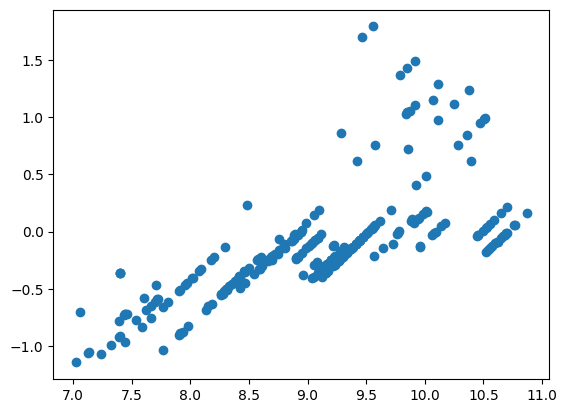

In [44]:
plt.scatter(y_test, residuals)

In [45]:
import xgboost as xg

xgbr = xg.XGBRegressor(objective = 'reg:squarederror', n_estimators = 10, seed = 123)
xgbr.fit(X_train_stand, y_train)
pred = xgbr.predict(X_test_stand)
xgb_r2 = r2_score(y_test, pred)
print("R2:", xgb_r2)

R2: 0.6921389903119035
